In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [ ]:
!pip install scikit-plot transformers
!pip install textstat
!pip install scikit-learn
!pip install pymorphy2
!pip install rake_nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 73.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=f08886cbb26b328a785b3b5c379b8b1c3d78bde8e217f94f040b5fbd0f084942
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
# Импорт библиотек

import time
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate,learning_curve, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Функция логгирования
import logging
loggers = {}

def set_logger(name, level):
    """
    Создает или возвращает логгер с указанным именем и уровнем логирования.

    Эта функция предназначена для настройки логгирования в приложениях Python. Она позволяет создать логгер с заданным именем,
    если он еще не был создан, или вернуть существующий логгер. Функция также настраивает форматирование сообщений логгера и
    добавляет обработчики для записи логов в файл и вывода в консоль.

    Параметры:
    name : str
        Имя логгера.
    level : int
        Уровень логирования, например, logging.DEBUG или logging.INFO.

    Возвращает:
    logger : logging.Logger
        Настроенный логгер.

    Пример использования:
    >>> logger = set_logger('example_logger', logging.DEBUG)
    >>> logger.info('Это информационное сообщение')
    [2024.06.27_18.43.45][INFO] ## Это информационное сообщение
    """

    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()

        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        logger.addHandler(ch)

        loggers[name] = logger
        return logger

logger = set_logger('sentiment_analysis_finphrase', logging.DEBUG)


In [ ]:
# Установка параметра Random Seed для воспроизводимости результатов обучения
import random
import torch
random.seed(42)
np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
def metric(y_true, y_pred):
    """
    Вычисляет метрики точности и F1-меры для оценки модели.

    Данная функция предназначена для использования в машинном обучении, где важно оценить качество модели на основе её предсказаний.

    Параметры:
    y_true : array-like
        Истинные метки классов.
    y_pred : array-like
        Предсказанные моделью метки классов.

    Возвращает:
    acc : float
        Точность модели как долю правильно предсказанных меток.
    f1 : float
        F1-мера модели, вычисленная как средневзвешенное значение F1-мер для каждого класса.

     """
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [ ]:
# Шаблон вывода метрик по всем моделям для сравнения
result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['TF-IDF', 'LSTM', 'DISTIL_BERT', 'RUBERT'])

#**РАЗВЕДЫВАТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ**

In [ ]:
# Загружаем набор данных для анализа
df = pd.read_csv('/content/news_2014_2023_scored.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302019 entries, 0 to 302018
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Link       302019 non-null  object 
 1   Date       302019 non-null  object 
 2   Title      302019 non-null  object 
 3   Score      302019 non-null  float64
 4   Sentiment  302019 non-null  object 
dtypes: float64(1), object(4)
memory usage: 11.5+ MB


,Link,Date,Title,Score,Sentiment
0,https://www.finam.ru/publications/item/dve-tre...,2014-01-01,Две трети россиян не имеют вкладов в банках,-0.443525,отрицательный
1,https://www.finam.ru/publications/item/inflyac...,2014-01-01,"Инфляция в РФ в 2013 году, по предварительным ...",0.099238,нейтральный
2,https://www.finam.ru/publications/item/rossiya...,2014-01-01,"Россия начинает председательство в G8, главная...",0.470865,положительный
3,https://www.finam.ru/publications/item/putin-o...,2014-01-01,Путин обещает продолжить борьбу с террористами...,-0.034546,нейтральный
4,https://www.finam.ru/publications/item/kapital...,2014-01-01,Капитала много не бывает! Сохраняйте и приумно...,-0.121388,нейтральный


In [ ]:
print('Общее количество записей в файле: ', df.shape[0])
df.drop_duplicates(inplace=True)
print('Общее количество записей после удаления дубликатов: ', df.shape[0])
df.reset_index(inplace=True, drop=True)

Общее количество записей в файле:  302019
Общее количество записей после удаления дубликатов:  273993


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


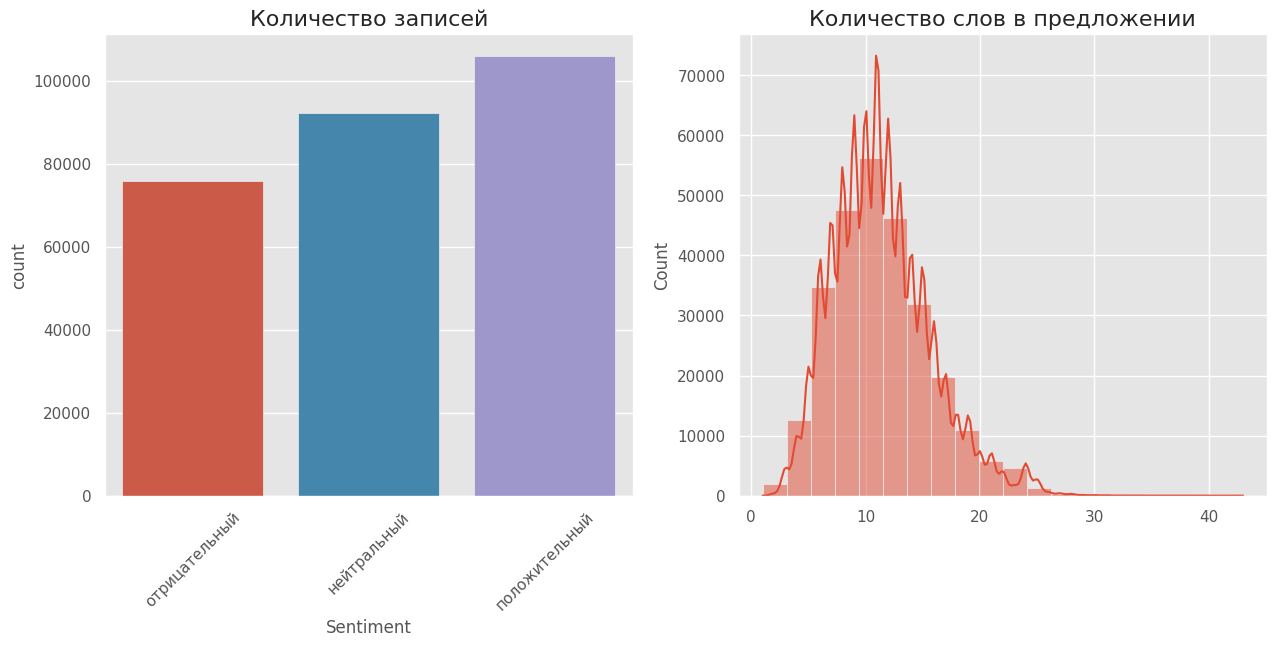

In [ ]:
# Создание визуализации
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
plt.style.use('ggplot')
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly.io as pio
pio.renderers.default = 'colab'

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from rake_nltk import Rake

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords = set(stopwords.words('russian'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Визуализация количества предложений с нейтральным, отрицательным и положительным сентиментом
sns.countplot(x='Sentiment', data=df, hue='Sentiment', ax=ax1)

ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_title('Количество записей', fontsize=16)

# Расчет длины слов в каждом предложении и создание гистограммы распределения данных
word_lengths = [len(nltk.word_tokenize(words)) for words in df['Title'] if isinstance(words, str) and words.strip()]
sns.histplot(word_lengths, bins=20, kde=True, ax=ax2)
ax2.set_title('Количество слов в предложении', fontsize=16)

plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Cоздадим экземпляр класса StratifiedKFold из библиотеки scikit-learn, который используется для кросс-валидации
kfold = StratifiedKFold(n_splits=7)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

Стратифицированная кросс-валидация гарантирует, что каждый фолд является хорошим представителем всего набора данных, сохраняя процентное соотношение каждого класса целевой переменной.
Количество фолдов, на которые будет разделен набор данных (в нашем случае это 7), означает, что в каждом эксперименте кросс-валидации будет использоваться 6 фолдов для обучения и 1 фолд для тестирования.

In [ ]:
# Применение функции для расчета максимальной длины новостного заголовка

import textstat
df['Sentence length'] = df['Title'].apply(lambda x : textstat.lexicon_count(x, removepunct=True))

In [ ]:
# Вычисление минимум, максимум и медианы
min_count = df['Sentence length'].min()
max_count = df['Sentence length'].max()
median_count = df['Sentence length'].median()

# Вывод результатов
print(f"Минимум: {min_count}")
print(f"Максимум: {max_count}")
print(f"Медиана: {median_count}")

Минимум: 1
Максимум: 29
Медиана: 9.0


In [ ]:
df_positive = df.loc[df['Sentiment'] == 'положительный']
df_negative = df.loc[df['Sentiment'] == 'отрицательный']
df_neutral = df.loc[df['Sentiment'] == 'нейтральный']

fig = make_subplots(rows=1, cols=3)

fig.append_trace(
    go.Box(name='Положительный', y=df_positive['Sentence length']),
    row=1, col=1
)

fig.append_trace(
    go.Box(name='Отрицательный', y=df_negative['Sentence length']),
    row=1, col=2
)

fig.append_trace(
    go.Box(name='Нейтральный', y=df_neutral['Sentence length']),
    row=1, col=3
)

fig.update_layout(height=500, width=700, title_text="Распределение длины предложений в разных классах")
fig.show()

Распределение новостных заголовкой по длине предложений практически идентично во всех трех классах с медианным значением 9-10 слов. (Примечание: если навести курсор на изображение, то можно получить более детальные ститистики по каждому классу).

In [ ]:
# Разделение корпуса текстов по классам в зависимости от их тональности
r = Rake()

negative_corpus = df_negative['Title'].tolist()
negative_corpus = " ".join(negative_corpus)
r.extract_keywords_from_text(negative_corpus)
top_phrases_neg = r.get_ranked_phrases()[0:100]


positive_corpus = df_positive['Title'].tolist()
positive_corpus = " ".join(positive_corpus)
r.extract_keywords_from_text(positive_corpus)
top_phrases_pos = r.get_ranked_phrases()[0:100]


neutral_corpus = df_neutral['Title'].tolist()
neutral_corpus = " ".join(neutral_corpus)
r.extract_keywords_from_text(neutral_corpus)
top_phrases_neutral = r.get_ranked_phrases()[0:100]

pd.DataFrame({'Top Negative Phrases':top_phrases_neg,'Top Positive Phrases':top_phrases_pos,'Top Neutral Phrases':top_phrases_neutral})

In [ ]:
train_df = df
# Примеры
pd.set_option('display.max_colwidth', 50)
train_df.sample(n=10, random_state=42)

,Link,Date,Title,Score,Sentiment,Sentence length
99860,https://www.finam.ru/publications/item/rynok-r...,2016-12-15,"Рынок РФ начал день снижением, падают ""ДИКСИ"",...",-0.862163,отрицательный,12
174033,https://www.finam.ru/publications/item/oak-ne-...,2019-06-06,ОАК не планирует выплачивать дивиденды-2018,-0.253017,нейтральный,5
207779,https://www.finam.ru/publications/item/sobytiy...,2020-07-27,"События предстоящего дня: ""Яндекс"", ""Энел Росс...",0.489433,положительный,12
101822,https://www.finam.ru/publications/item/statist...,2017-01-10,Статистика укрепила евро,0.371925,положительный,3
260455,https://www.finam.ru/publications/item/mirovye...,2023-05-18,Мировые рынки приветствуют прогресс переговоро...,0.461906,положительный,10
191028,https://www.finam.ru/publications/item/po-mere...,2019-12-30,По мере приближения праздников активность торг...,-0.557274,отрицательный,8
162075,https://www.finam.ru/publications/item/na-rynk...,2019-01-18,На рынке США оптимизм остается драйвером роста,0.480440,положительный,7
21229,https://www.finam.ru/publications/item/fitch-v...,2014-08-14,Fitch: Высокое отношение кредитов к депозитам ...,-0.593726,отрицательный,14
198733,https://www.finam.ru/publications/item/mir-pos...,2020-04-11,"Мир постепенно идет на поправку, поэтому сейча...",0.291001,нейтральный,12
215226,https://www.finam.ru/publications/item/mirovye...,2020-11-03,Мировые фондовые площадки демонстрируют положи...,0.354265,положительный,6


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Использрование One-Hot Encoder для приведения значений в колонке 'Sentiment' в числовой формат
le = LabelEncoder()
le.fit(train_df['Sentiment'])
print(list(le.classes_))
train_df['Sentiment'] = le.transform(train_df['Sentiment'])
train_df['Sentiment']

['нейтральный', 'отрицательный', 'положительный']


,Sentiment
0,1
1,0
2,2
3,0
4,0
...,...
273988,1
273989,1
273990,2
273991,0


In [ ]:
import string
from collections import defaultdict

def create_corpus(df):
    """
    Создает корпус слов из колонки 'Title' в DataFrame.

    Эта функция проходит по каждому предложению в колонке 'Title' DataFrame,
    удаляет все числа, символы и пунктуационные знаки из каждого слова, приводит слова к нижнему регистру
    и добавляет их в корпус.

    Параметры:
    df (pandas.DataFrame): DataFrame, содержащий колонку 'Title', из которой будет создан корпус.

    Возвращает:
    list: Список слов (корпус), где каждое слово представлено в нижнем регистре и очищено от чисел,
    символов и пунктуационных знаков.

    """
    corpus = []

    for x in df['Title'].str.split():
        for i in x:
            # Удаление чисел, символов и пунктуационных знаков
            i = ''.join(char for char in i if char.isalpha() and char not in string.ascii_letters and char not in string.punctuation)
            corpus.append(i.lower())
    return corpus


def get_frequent_stop_words(corpus, top_n=50):
    """
    Получает наиболее часто встречающиеся стоп-слова в заданном корпусе.

    Args:
        corpus (list): Список слов, представляющих текстовый корпус.
        top_n (int): Количество наиболее часто встречающихся слов, которые нужно вернуть (по умолчанию 50).

    Returns:
        tuple: Кортеж, содержащий два списка - список наиболее частых стоп-слов и список их частот.
    """
    dic = defaultdict(int)
    for word in corpus:
        if word in stopwords:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)


def get_frequent_nonstop_words(corpus, top_n=50):
    """
    Получает наиболее часто встречающиеся слова, не входящие в стоп-список, в заданном корпусе.

    Args:
        corpus (list): Список слов, представляющих текстовый корпус.
        top_n (int): Количество наиболее часто встречающихся слов, которые нужно вернуть (по умолчанию 50).

    Returns:
        tuple: Кортеж, содержащий два списка - список наиболее частых не-стоп-слов и список их частот.
    """
    dic = defaultdict(int)
    for word in corpus:
        if word not in stopwords:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)


# Создание корпуса
corpus = create_corpus(train_df)

In [ ]:
# Наиболее часто встречающиеся слова не из списка стоп-слов
x,y = get_frequent_nonstop_words(corpus)

print(f'Наиболее частые слова не из стоп-листа: {x}')
print(f'Частотность: {y}')

Наиболее частые слова не из стоп-листа: ('', 'сша', 'индекс', 'млрд', 'ожидалось', 'рублей', 'рф', 'года', 'рынок', 'пунктов', 'россии', 'нефть', 'прибыль', 'цен', 'акции', 'гг', 'млн', 'году', 'нефти', 'акций', 'рынке', 'рубля', 'роста', 'торгов', 'составил', 'рынка', 'рубль', 'квартале', 'сегодня', 'рост', 'индексы', 'активности', 'мм', 'деловой', 'снизился', 'итогам', 'цб', 'рынки', 'год', 'продажи', 'фьючерсы', 'российский', 'долларов', 'пункта', 'ммвб', 'неделю', 'могут', 'цены', 'рынках', 'фондовых')
Частотность: (294290, 30579, 22684, 19158, 14815, 12817, 12621, 12150, 11623, 11020, 10438, 9671, 9128, 8294, 8208, 7855, 7636, 7633, 7484, 7469, 7048, 6624, 6544, 6440, 6349, 6279, 6100, 6076, 5996, 5958, 5656, 5591, 5146, 5009, 4989, 4955, 4952, 4938, 4916, 4839, 4826, 4735, 4645, 4561, 4523, 4410, 4340, 4243, 4169, 4151)


In [ ]:
# наиболее часто встречающиеся слова из списка стоп-слов
x, y = get_frequent_stop_words(corpus)
stopwords = nltk.corpus.stopwords.words('russian')

print(f'Количество стоп-слов: {len(stopwords)}')
print(f'Стоп-слова: {x}')
print(f'Частотность: {y}')

Количество стоп-слов: 151
Стоп-слова: ('в', 'на', 'и', 'по', 'за', 'до', 'с', 'не', 'может', 'к', 'для', 'о', 'будет', 'от', 'из', 'что', 'после', 'у', 'во', 'более', 'под', 'но', 'перед', 'еще', 'как', 'при', 'ли', 'если', 'об', 'все', 'быть', 'нет', 'без', 'чем', 'со', 'уже', 'а', 'есть', 'почти', 'можно', 'вам', 'вас', 'лучше', 'или', 'между', 'чего', 'сейчас', 'больше', 'через', 'раз')
Частотность: (122517, 114436, 30488, 27667, 26164, 24914, 17522, 14857, 13717, 12814, 12201, 8422, 6238, 6020, 4993, 4231, 3170, 2886, 2760, 2414, 2408, 2259, 2164, 2010, 1923, 1764, 1570, 1522, 1505, 1443, 1437, 1393, 1393, 1392, 1366, 1323, 980, 977, 940, 875, 862, 860, 729, 709, 705, 687, 669, 619, 609, 586)


In [ ]:
# Создадим список стоп-слов для отображения в "мешке слов"
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
russian_stopwords = set([
    'в', 'и', 'на', 'с', 'по', 'что', 'для', 'за', 'до', 'о', 'а', 'будет', ''\
    'от', 'из', 'как', 'не', 'к', 'более', 'ее', 'он', 'после', 'во', 'чем', 'себя',\
    'мы', 'его', 'со', 'или', 'у', 'то', 'чтобы', 'было', 'того', 'она', 'был', 'при',\
    'том', 'об', 'свою', 'так', 'была', 'был', 'быть', 'были', 'все', 'же', 'тем', \
    'еще', 'через', 'может', 'могут', 'под', 'уже', 'их', 'этом', 'между', 'они', 'всех', 'без',\
    'всего', 'этого', 'когда', 'только', 'два', 'теперь', 'этот', 'тот', 'почти', 'эти',\
    'где', 'один', 'но', 'можно', 'есть', 'этой', 'если', 'я', 'три', 'нас', 'нам'\
    'над', 'них', 'бы', 'раз', 'вы', 'нет', 'сейчас', 'ли', 'другой', 'потому', 'всю',\
    'ему', 'него', 'кто', 'перед', 'эту', 'ним', 'такой', 'там', 'им', 'чего',\
    'чуть', 'конечно', 'даже', 'вас', 'нее', 'совсем', 'здесь', 'всегда', 'ей', 'себе',\
    'тогда', 'ни', 'ней', 'опять', 'сам', 'мой', 'да', 'вам', 'ничего', 'моя', 'зачем',\
    'тоже', 'также', 'который', 'которые', 'которая', 'которое', 'свой', 'своя', 'своей',\
    'это', 'эта', 'этот', 'эти', 'около', 'гг', 'г', 'свой', 'свои', 'млн', 'сказал', 'сообщил',\
    'имеет', 'имеют','будут', 'является', 'являлся', 'являются', 'являлась', 'именно', 'сегодня', \
    'ожидалось', 'сообщалось', 'сообщается', 'сообщила', 'сообщает', 'сообщил', 'сообщают', 'млрд', 'год', 'года',\
    'году', 'поскольку', 'какой', 'заявляет', 'заявил', 'заявила', 'отметил', 'отметила', 'отмечает', \
    'ожидалось', 'мм', 'вчера', 'завтра', 'на днях', 'составил', 'составляет', 'составила', 'квартале'\

])
# Использование списка стоп-слов на русском языке
stopwords.update(russian_stopwords)

text = " ".join(corpus)

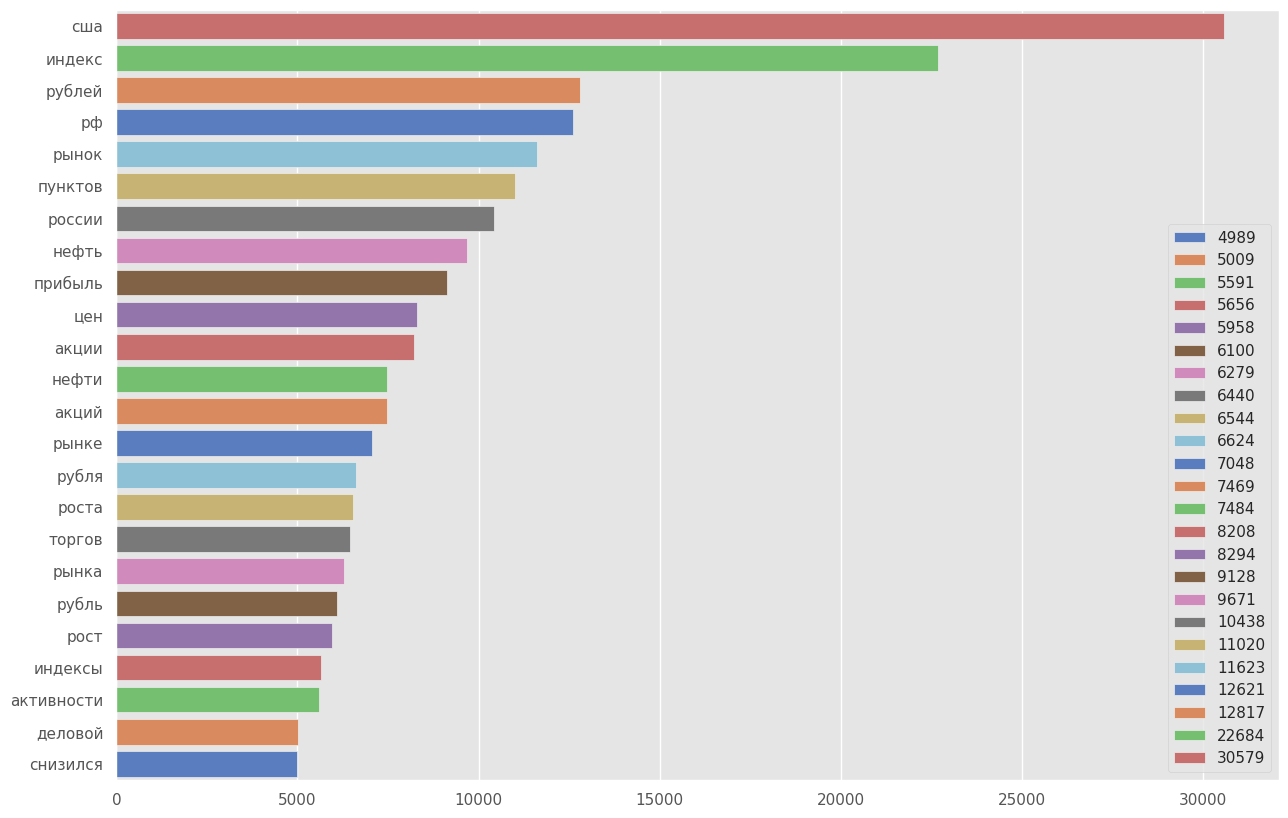

In [ ]:
# Визуализация наиболее часто встречающихся слов, которые не находятся в списке стоп-слов
counter = Counter(corpus)
most = counter.most_common()[:50]
x, y = [], []
for word, count in most:
    if word not in russian_stopwords and word != '':
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,10))
sns.barplot(x=y, y=x, palette="muted", hue=y)
plt.show()

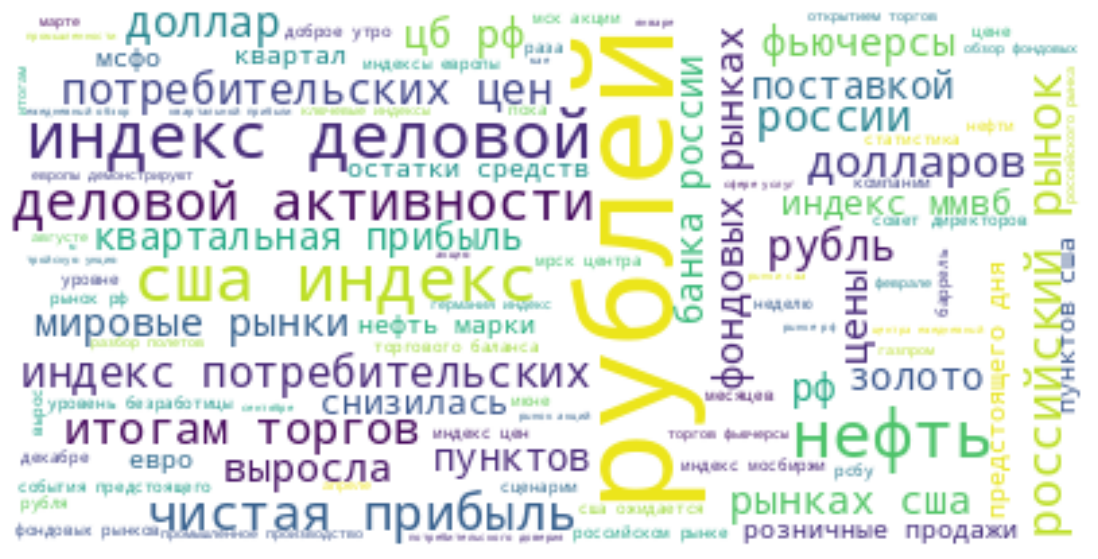

In [ ]:
# Создание тематического облака слов
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Параметры изображения
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Создадим "облако слов"
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

"Мешок слов" демонстрирует тематически наиболее значимые слова в наборе данных.

#**Применение TF-IDF подхода**

TF-IDF (Term Frequency-Inverse Document Frequency) - это статистическая мера, используемая для оценки важности слова в контексте документа, входящего в некоторую коллекцию документов (корпус). Она состоит из двух компонентов:

1. Частота термина (Term Frequency, TF):
   - Это простой подсчет частоты, с которой слово появляется в данном документе.
   - Чем чаще слово встречается в документе, тем более важным оно считается в этом документе.

2. Обратная частота документа (Inverse Document Frequency, IDF):
   - Это мера того, насколько важно слово в корпусе документов.
   - Если слово встречается во многих документах, то оно, как правило, менее информативно, чем слово, которое встречается в меньшем числе документов.
   - IDF рассчитывается как логарифм от отношения общего числа документов к числу документов, содержащих данное слово.
   
TF-IDF вычисляется как произведение TF и IDF, что позволяет выявить слова, которые являются наиболее характерными для данного набора данных.


In [ ]:
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

In [ ]:
from collections import Counter
from nltk import ngrams
from tqdm import tqdm
from nltk.tokenize import word_tokenize

# Функция для лемматизации слова
def lemmatize_word(word):
    return morph.parse(word)[0].normal_form

def tokenize_df(train_df, col='Title', lemma=True, remove_stopwords=True, tokenizer='pymorphy2', n=2):
    tokenized = []
    for text in tqdm(train_df[col]):
        if tokenizer == 'razdel':
            words = [word.lower() for word in word_tokenize(text) if word.isalpha()]
        else:
            words = re.findall(r'\b([а-яА-Я]+)\b', text.lower())

        if remove_stopwords:
            words = [word for word in words if word not in stopwords]

        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            if n > 1:
                n_grams = list(ngrams(tokens, n))
                tokenized.append((tokens, n_grams))
            else:
                tokenized.append((tokens,))
        else:
            if n > 1:
                n_grams = list(ngrams(words, n))
                tokenized.append((words, n_grams))
            else:
                tokenized.append((words,))

    tokenized_text = [" ".join(words) for words, _ in tokenized]

    all_words = [word for text_tuple in tokenized for word in text_tuple[0]]

    counts = Counter(all_words)
    bow = sorted(counts, key=counts.get, reverse=True)

    vocab = {word: idx + 1 for idx, word in enumerate(counts)}
    id2vocab = {v: k for k, v in vocab.items()}

    token_ids = [[vocab[word] for word in text_tuple[0]] for text_tuple in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids


100%|██████████| 273993/273993 [05:43<00:00, 797.55it/s] 


<Axes: ylabel='Count'>

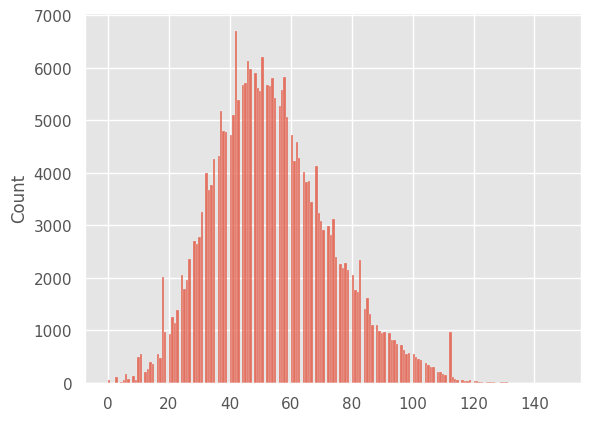

In [ ]:
# Tокенизация
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_df, col='Title', lemma=True, remove_stopwords=True, tokenizer='pymorphy2', n=4)
sns.histplot([len(x) for x in tokenized_text])


In [ ]:
# Выделение целевой переменной
Y_data = df['Sentiment']
X_data = tokenized_text

# Разделение на обучающую и тестовую выборку
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

In [ ]:
# Функция обучения модели и визуализации результатов

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    """
    Функция для обучения модели с помощью GridSearchCV и визуализации результатов.

    Параметры:
    estimator (obj): Объект классификатора, который будет обучаться.
    param_grid (dict): Словарь с параметрами для поиска по сетке.
    scoring (dict): Словарь с метриками для оценки качества модели.
    refit (str): Название метрики для финального обучения модели.
    cv (int, optional): Число разбиений для перекрестной проверки. По умолчанию 5.
    verbose (int, optional): Уровень детализации вывода. По умолчанию 1.
    plot (bool, optional): Флаг отображения визуализации. По умолчанию True.

    Возвращает:
    obj: Обученная модель с наилучшими параметрами.

    Примечания:
    - Функция использует библиотеку Scikit-learn для поиска оптимальных параметров модели.
    - Результаты обучения и метрики качества выводятся на консоль.
    - При установке флага `plot=True` будут отображены следующие графики:
        1. Зависимость значений метрик на тренировочном и тестовом множествах.
        2. Зависимость значений метрик от первого параметра из `param_grid`.
        3. Кривые обучения (Learning Curve) для точности и F1-меры.
    """

    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose,
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)

    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']

    print("Лучший результат: ", model.best_score_)
    print("Параметры модели: ", model.best_params_)

    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)

        ### Первый график ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)

        ### Второй график ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)
        # Получаем стандартный NumPy-массив из объекта MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]
            # Нарисуем вертикальную пунктирную линию в точке наилучшей метрики
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Лучший показатель для данной метрики
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        ### Третий график (Кривая обучения) ###
        # Кривая обучения для точности (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'],
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)

        # Кривая обучения для F1-меры
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'],
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)

        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")
        # Визуализируем кривую обучения для точности (Accuracy)
        ax3.fill_between(lc_acc_train_sizes,
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes,
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")

        # Визуализируем кривую обучения для F1-меры
        ax3.fill_between(lc_f1_train_sizes,
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes,
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)

        plt.tight_layout(pad=3.0)
        plt.show()

    return model

Применим алгоритмы, показавшие лучшие результаты на адаптированном наборе данных.

Fitting 7 folds for each of 60 candidates, totalling 420 fits
Лучший результат:  0.8179376336281781
Параметры модели:  {'clf__alpha': 0.001, 'clf__class_weight': 'balanced', 'clf__loss': 'perceptron', 'clf__penalty': 'l2'}
[2024-08-19 21:56:56,062][INFO] ## Training - acc: 0.98536456, f1: 0.98602094


INFO:sentiment_analysis_finphrase:Training - acc: 0.98536456, f1: 0.98602094


[2024-08-19 21:56:56,101][INFO] ## Test - acc: 0.82371941, f1: 0.82222579


INFO:sentiment_analysis_finphrase:Test - acc: 0.82371941, f1: 0.82222579


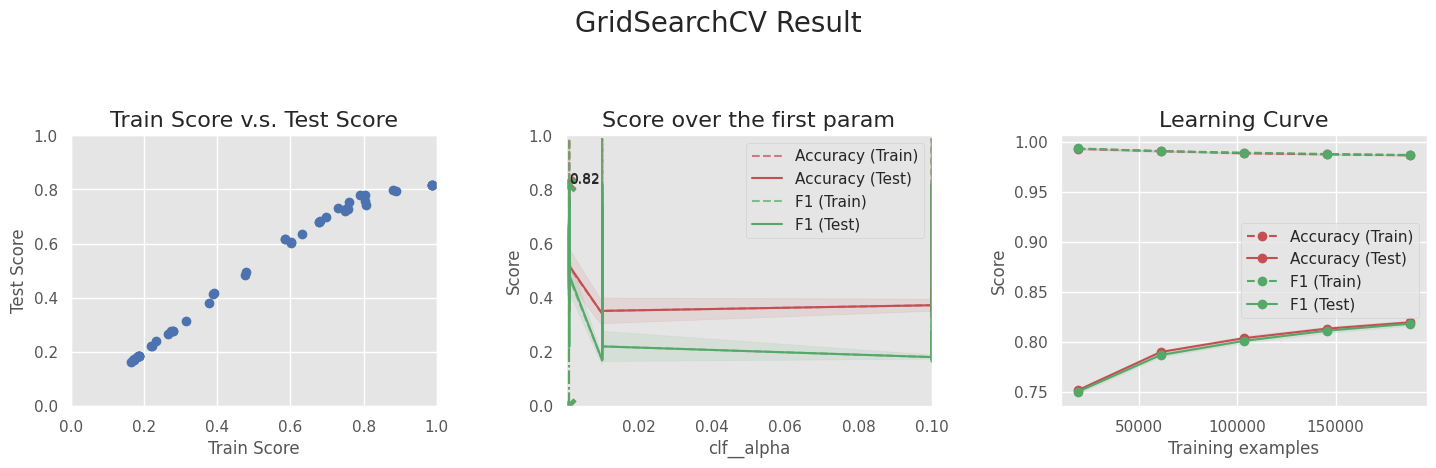

Время работы алгоритма: 15284.53 секунд


In [ ]:
# Подбор параметров для стохастического градиентного спуска (SGDClassifier)

pipeline = Pipeline([
    ('vec', TfidfVectorizer(ngram_range=(1, 4))),
    ('clf', SGDClassifier())
])

param_grid = {
    'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'clf__class_weight': ['balanced']
}

# Начало отсчета времени обучения
start_time = time.time()

# Обучение модели
SGD_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)

# Конец отсчета времени
end_time = time.time()

# Вывод затраченного времени
elapsed_time = end_time - start_time
print(f"Время работы алгоритма: {elapsed_time:.2f} секунд")
SGD_best = SGD_model.best_estimator_


In [ ]:
# Метрики лучшей модели
pred_test = SGD_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['TF-IDF_SGD'] = (round(acc,4), round(f1,4))
result_df.loc['TF-IDF_SGD']

,TF-IDF_SGD
Accuracy,0.8237
F1,0.8222


В случае применения алгоритма стохастического градиентного спуска в результате обучения классификатора на массиве новостей, собранных за 10 лет, удалось повысить точность предсказаний в среднем с 81% до 82%.

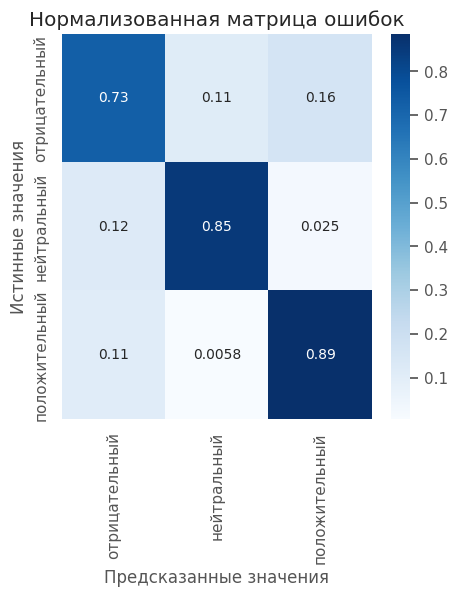

In [ ]:
# Создание матрицы ошибок

conf_mat = confusion_matrix(Y_test, pred_test, normalize='true')

class_names = ['отрицательный','нейтральный','положительный']

plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='Blues')

plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Нормализованная матрица ошибок')
plt.show()

Модель SGD хорошо справляется с предскзаниями положительного (89%) и нейтрального сентимента (85%), при этом количество ошибок в классе с отрицательным сентиментом требует коррекции.

Fitting 7 folds for each of 6 candidates, totalling 42 fits
Лучший результат:  0.8267376164604547
Параметры модели:  {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
[2024-08-20 09:46:40,916][INFO] ## Training - acc: 0.95154521, f1: 0.95235746


INFO:sentiment_analysis_finphrase:Training - acc: 0.95154521, f1: 0.95235746


[2024-08-20 09:46:40,958][INFO] ## Test - acc: 0.82862826, f1: 0.82658068


INFO:sentiment_analysis_finphrase:Test - acc: 0.82862826, f1: 0.82658068


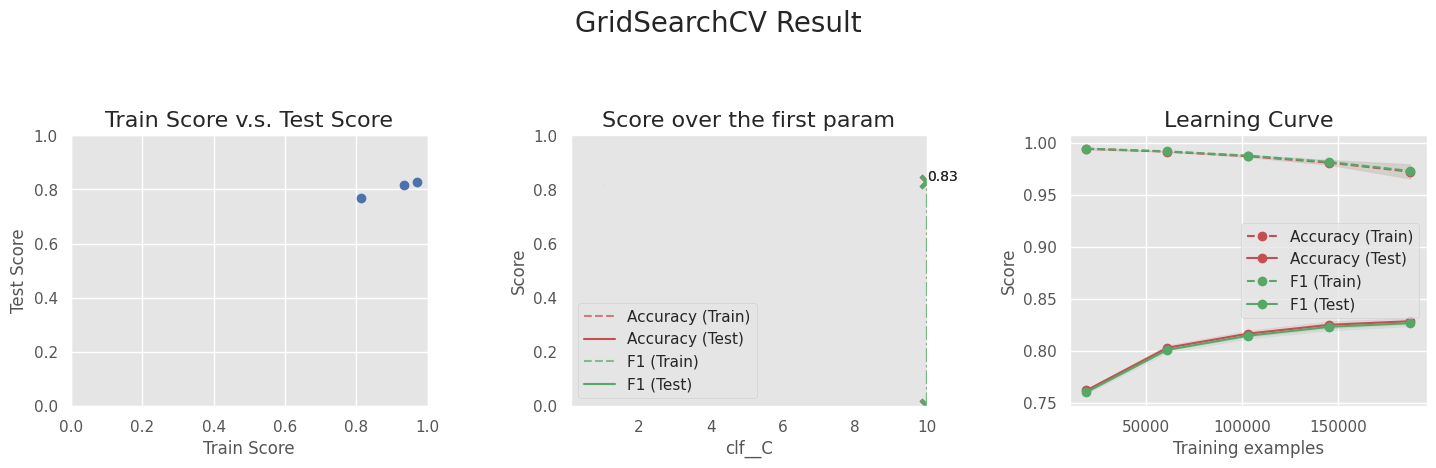

Время работы алгоритма: 5820.59 секунд


In [ ]:
# Подбор параметров для логистической регрессии (LogisticRegression)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
    ('vec', TfidfVectorizer(ngram_range=(1, 4))),
    ('clf', LogisticRegression())
])

param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__class_weight': ['balanced']
}
# Начало отсчета времени обучения
start_time = time.time()

LR_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)

# Конец отсчета времени
end_time = time.time()

# Вывод затраченного времени
elapsed_time = end_time - start_time
print(f"Время работы алгоритма: {elapsed_time:.2f} секунд")

LR_best = LR_model.best_estimator_

Алгоритм логистической регрессии показал среднюю точность на тестовой выборке 83%, что позволило улучшить результат классификатора, обученного на адаптированном с английского наборе данных "Financial Phrasebank", на 3% (с 80 до 83%).

In [ ]:
# Метрики лучшей LR модели

pred_test = LR_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['TF-IDF_LR'] = (round(acc,4), round(f1,4))
result_df.loc['TF-IDF_LR']

,TF-IDF_LR
Accuracy,0.8286
F1,0.8266


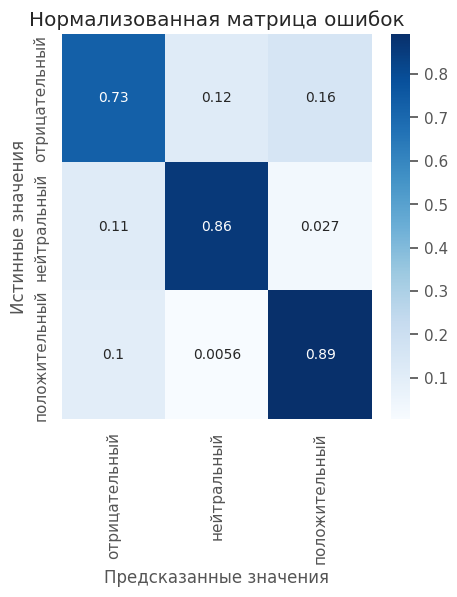

In [ ]:
# Создание матрицы ошибок

conf_mat = confusion_matrix(Y_test, pred_test, normalize='true')

class_names = ['отрицательный','нейтральный','положительный']

plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='Blues')

plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Нормализованная матрица ошибок')
plt.show()

В результате использования алгоритма логистической регрессии мы видим в целом улучшение качества предсказаний (89% для положительного класса, 86% для нейтрального класса и 73% для отрицательного класса), однако, дисбаланс в пользу точности положительных предсказаний сохраняется.  

# **Использование синтетических данных**

Используем синтетические данные для повышения количества образцов в классе с отрицательным и нейтральным сентиментом для улучшения результатов предсказаний.

In [ ]:
import pandas as pd
df = pd.read_csv('/content/news_2014_2023_scored.csv')
df_neutral = df[(df['Sentiment']=='нейтральный')]
df_negative = df[(df['Sentiment']=='отрицательный')]
df_positive = df[(df['Sentiment']=='положительный')]

count_neutral = df_neutral.shape[0]
count_negative = df_negative.shape[0]
count_positive = df_positive.shape[0]

print(f"Количество нейтральных новостей: {count_neutral}")
print(f"Количество отрицательных новостей: {count_negative}")
print(f"Количество положительных новостей: {count_positive}")

Количество нейтральных новостей: 102438
Количество отрицательных новостей: 83657
Количество положительных новостей: 115924


In [ ]:
from sklearn.utils import resample
# Использоание ап-сэмплинга для балансировки классов (увеличение образцов в классах с нейтральным и отрицательным сентиментом)
# Среднее количество
average_samples = (102438 + 83657 + 115924) // 3
print(average_samples)

# Ап-сэмплинг отрицательных новостей
df_negative_upsampled = resample(df_negative,
                                  replace=True,
                                  n_samples=115924,
                                  random_state=42)

# Ап-сэмплинг нейтральных новостей
df_neutral_upsampled = resample(df_neutral,
                                 replace=True,
                                 n_samples=115924,
                                 random_state=42)

# Объединение
df = pd.concat([df_negative_upsampled, df_neutral_upsampled, df_positive])



100673


In [ ]:
# Кодирование меток сентимента
df['Label'], unique = pd.factorize(df['Sentiment'])

df.head()

,Link,Date,Title,Score,Sentiment,Label
53804,https://www.finam.ru/publications/item/dolya-o...,2015-07-31,"Доля основного акционера ОВК снизилась до 74,71%",-0.656848,отрицательный,0
3052,https://www.finam.ru/publications/item/onlaiyn...,2014-02-06,Онлайн-конференция: Металлургия и горнодобыча ...,-0.592303,отрицательный,0
276775,https://www.finam.ru/publications/item/tsenovy...,2022-12-05,Ценовые ограничения не затронут российскую неф...,-0.351341,отрицательный,0
202824,https://www.finam.ru/publications/item/avstriy...,2020-05-29,Австрия: индекс цен производителей снизился в ...,-0.641261,отрицательный,0
21641,https://www.finam.ru/publications/item/ryady-b...,2014-08-19,"Ряды ""быков"" редеют, вероятность коррекции на ...",-0.366976,отрицательный,0


100%|██████████| 347772/347772 [07:59<00:00, 724.60it/s]


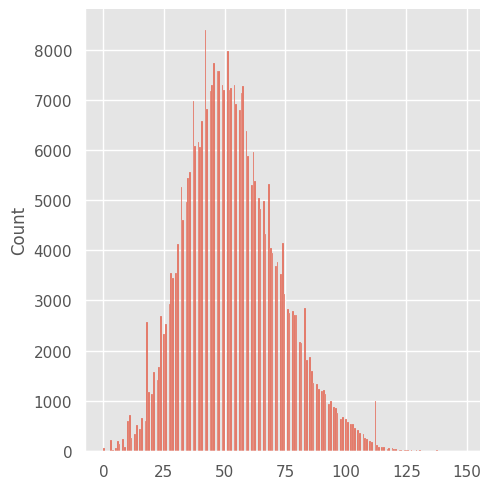

In [ ]:
# Tокенизция
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(df, col='Title', lemma=True, remove_stopwords=True, tokenizer='pymorphy2', n=4)
sns.histplot([len(x) for x in tokenized_text])

In [ ]:
# Выделение целевой переменной
Y_data = df['Sentiment']
X_data = tokenized_text

# Разделение на обучающую и тестовую выборку
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

In [ ]:
# Создание нового пайплайна с использованием настроенной модели LR_best

new_pipeline = Pipeline([
    ('cv', TfidfVectorizer(ngram_range=(1, 4))),  # Используем N-граммы
    ('clf', LR_best)  # Используем ранее обученную модель
])

# Начало отсчета времени обучения
start_time = time.time()

LR_best.fit(X_train,Y_train)

# Конец отсчета времени
end_time = time.time()

# Вывод затраченного времени
elapsed_time = end_time - start_time
print(f"Время работы алгоритма: {elapsed_time:.2f} секунд")
print('Лучший результат: ')
LR_best.score(X_test, Y_test)

Время работы алгоритма: 132.23 секунд
Лучший результат: 


0.913694198835454

In [ ]:
# Метрики
y_pred = LR_best.predict(X_test)
print("TF-IDF подход с использованием балансировки классов: "+"\n")
pd.DataFrame(classification_report(y_pred,Y_test,output_dict=True)).T

TF-IDF подход с использованием балансировки классов: 



,precision,recall,f1-score,support
нейтральный,0.869957,0.884327,0.877083,22823.000000
отрицательный,0.950172,0.948129,0.949150,23250.000000
положительный,0.920967,0.908142,0.914510,23482.000000
accuracy,0.913694,0.913694,0.913694,0.913694
macro avg,0.913699,0.913533,0.913581,69555.000000
weighted avg,0.913992,0.913694,0.913808,69555.000000


In [ ]:
# Создание нового пайплайна с использованием настроенной модели SGD_best

new_pipeline = Pipeline([
    ('cv', TfidfVectorizer(ngram_range=(1, 4))),  # Используем N-граммы
    ('clf', SGD_best)  # Используем ранее обученную модель
])

# Начало отсчета времени обучения
start_time = time.time()

SGD_best.fit(X_train,Y_train)

# Конец отсчета времени
end_time = time.time()

# Вывод затраченного времени
elapsed_time = end_time - start_time
print(f"Время работы алгоритма: {elapsed_time:.2f} секунд")
print('Лучший результат: ')
SGD_best.score(X_test, Y_test)

Время работы алгоритма: 27.93 секунд
Лучший результат: 


0.9153619437854935

Дообучение классификатора на основе градиентного спуска позволило достичь точности в 92%.

In [ ]:
# Метрики
y_pred = SGD_best.predict(X_test)
print("TF-IDF подход с использованием балансировки классов: "+"\n")
pd.DataFrame(classification_report(y_pred,Y_test,output_dict=True)).T

TF-IDF подход с использованием балансировки классов: 



,precision,recall,f1-score,support
нейтральный,0.881336,0.878647,0.879990,23271.000000
отрицательный,0.951983,0.955112,0.953545,23124.000000
положительный,0.912762,0.912565,0.912663,23160.000000
accuracy,0.915362,0.915362,0.915362,0.915362
macro avg,0.915360,0.915441,0.915399,69555.000000
weighted avg,0.915287,0.915362,0.915323,69555.000000


Таким образом, помимо использования частотного подхода и N-грамм (перебор в диапазоне от 1 до 4) для лучшего контекста, после увеличения количества образцов в отрицательном и нейтральном классе, мы добились лучшей сбалансированности данных, что помогло улучшить результат и довести точность предсказаний у лучшего алгоритма до са. 92%.